In [1]:
import pandas as pd
df_old = pd.read_csv('train.csv')
to_drop = ['Sex', 'Age', 'Support Devices']
df_old = df_old.drop(columns=to_drop)
# remove Lateral rows
df_old = df_old[df_old['Frontal/Lateral'] != 'Lateral']
df_old.drop(columns=['Frontal/Lateral'], inplace=True)
# replace nan with 0 like chexpert paper
df_old.fillna(0.0, inplace=True)
# replace uncertain with 0.0
df_old.replace(-1.0, 0.0, inplace=True)
df_old.rename(columns={"Pleural Effusion":"Effusion"}, inplace=True)

In [2]:
common_diseases = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "No Finding",
    "Pneumonia",
    "Pneumothorax"
]
uncommon_diseases = ['Lung Opacity', 'Lung Lesion', 'Enlarged Cardiomediastinum', 'Pleural Other', 'Fracture']
# go through the dataframe and drop rows where there are no 1s for any common diseases 
df_old_2 = df_old.loc[(df_old[common_diseases] != 0.0).any(axis=1)]
cnt = df_old.shape[0] - df_old_2.shape[0]
print(f"Dropped {cnt} rows from the training dataset. {len(df_old_2)} rows remaining.")
# verify all rows have at least one 1 for common diseases
assert (df_old_2[common_diseases] != 0.0).any(axis=1).all()
# drop uncommon diseases
df_old_2.drop(columns=uncommon_diseases, inplace=True)

Dropped 39665 rows from the training dataset. 151362 rows remaining.


/tmp/ipykernel_219998/3023426774.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_2.drop(columns=uncommon_diseases, inplace=True)


In [3]:
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']
assert (df_old_2[(df_old_2[diseases] == 0).all(axis=1)]["No Finding"] == 1).all()

In [4]:
# extract the patient id from the path column
df_old_2['Patient ID'] = df_old_2['Path'].str.extract(r'patient(\d+)')

cols = ['Path', 'Patient ID', 'AP/PA'] + common_diseases
df_old_2 = df_old_2[cols]

/tmp/ipykernel_219998/2084234516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_2['Patient ID'] = df_old_2['Path'].str.extract(r'patient(\d+)')


In [ ]:
df_old_2.head(10)

In [6]:
# find duplicate rows, which are those where the Patientid, the projection and the labels are the same
# mark the last duplicates and remove them
cnt_before = len(df_old_2)
# # print a few duplicates to confirm
# df_old_2[df_old_2.duplicated(subset=["Patient ID", "AP/PA"]+common_diseases, keep=False)].head()
df_old_2.drop_duplicates(subset=["Patient ID", "AP/PA"]+common_diseases, keep="first", inplace=True)
# count the duplicates
print(f"Dropped {cnt_before - len(df_old_2)} duplicates. {len(df_old_2)} rows remaining in the training dataset.")

Dropped 45567 duplicates. 105795 rows remaining in the training dataset.


<Axes: title={'center': 'Label distribution CXP'}>

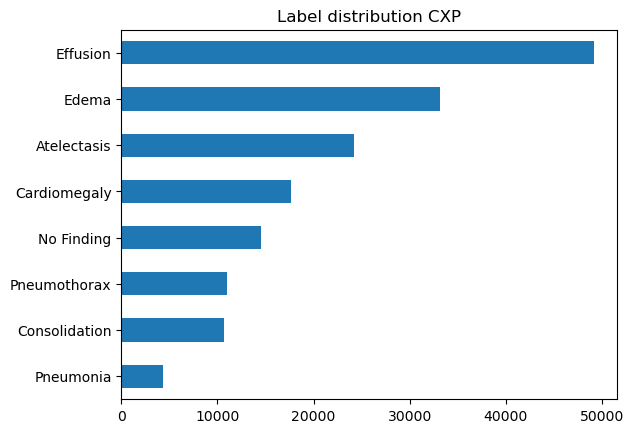

In [7]:
# label distribution
label_distribution = df_old_2[common_diseases].sum()
# plot as a horizontal bar chart, sorted
label_distribution.sort_values().plot(kind="barh", title="Label distribution CXP")

In [ ]:
# replace / with _ in Path, discard the first part of the path and keep only the filename
df_old_2['Path'] = df_old_2['Path'].str.replace("/", "_")
df_old_2['Path'] = df_old_2['Path'].str.split("_").str[2:]
df_old_2['Path'] = df_old_2['Path'].str.join("_")
df_old_2.head()

In [40]:
# save the dataframe to a new csv file 
df_old_2.to_csv("cxp_processed.csv", index=False)

In [54]:
# Now let's preprocess the images to 224x224 and CLAHE and save them to a new folder
import cv2
import os
from tqdm import tqdm

# create a new folder to save the images
if not os.path.exists("images_224"):
    os.makedirs("images_224")

# iterate through the rows of the dataframe
df_pre = pd.read_csv("cxp_processed.csv")
for index, row in tqdm(df_pre.iterrows(), total=len(df_pre)):
    # get the image id
    image_id = row["Path"]
    # add CheXpert directory to the path, replace _ with /, except the last _
    image_id_old = "CheXpert-v1.0/train/" + image_id.replace("_", "/", image_id.count("_")-1)
    # read the image
    img = cv2.imread(f"../{image_id_old}", cv2.IMREAD_GRAYSCALE)
    # crop 5% of the image from all sides to remove blown borders and artifacts
    img = img[int(img.shape[0]*0.05):int(img.shape[0]*0.95), int(img.shape[1]*0.05):int(img.shape[1]*0.95)]
    # resize the image to 224x224
    img = cv2.resize(img, (224, 224))
    # # apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # apply histogram equalization
    # img = cv2.equalizeHist(img)
    # save the image
    # make the necessary directories
    cv2.imwrite(f"images_224/{image_id}", img)

100%|██████████| 105795/105795 [4:04:41<00:00,  7.21it/s]  


In [10]:
# keep 10k images for testing
# find the number of unique patients
patients = df_pre['Patient ID'].unique()
# shuffle the patients
import numpy as np
np.random.seed(44)
np.random.shuffle(patients)
# check how many images the last 8k patients have
len(df_pre[df_pre['Patient ID'].isin(patients[:7356])])

# save the first 7356 patients to as the test set
df_test = df_pre[df_pre['Patient ID'].isin(patients[:7356])]
df_train_val = df_pre[~df_pre['Patient ID'].isin(patients[:7356])]
# save the test file
# df_test.to_csv("cxp_test.csv", index=False)


In [11]:
len(df_train_val), len(df_test)

(90795, 15000)

<Axes: title={'center': 'Label distribution CXP'}>

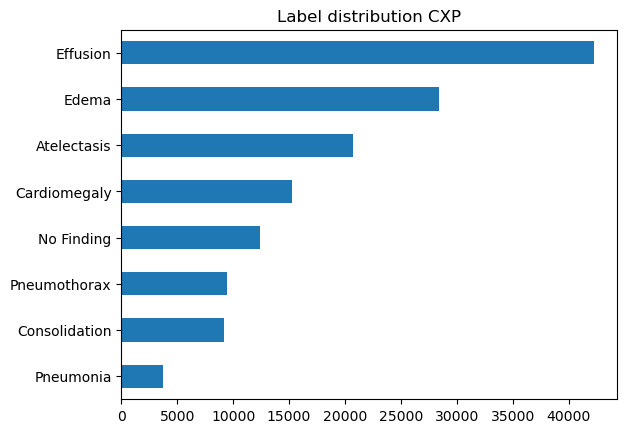

In [12]:
# plot the label distribution for the training and validation set
label_distribution = df_train_val[common_diseases].sum()
# plot as a horizontal bar chart, sorted
label_distribution.sort_values().plot(kind="barh", title="Label distribution CXP")


In [80]:
# count the co-occurrences of the diseases
co_occurrences = df_train_val[common_diseases].T.dot(df_train_val[common_diseases])
co_occurrences

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,No Finding,Pneumonia,Pneumothorax
Atelectasis,20726.0,2561.0,1430.0,5743.0,9678.0,0.0,413.0,1907.0
Cardiomegaly,2561.0,15237.0,979.0,6471.0,6663.0,0.0,319.0,518.0
Consolidation,1430.0,979.0,9185.0,2160.0,4648.0,0.0,618.0,465.0
Edema,5743.0,6471.0,2160.0,28392.0,13783.0,0.0,845.0,1001.0
Effusion,9678.0,6663.0,4648.0,13783.0,42239.0,0.0,1113.0,3502.0
No Finding,0.0,0.0,0.0,0.0,0.0,12409.0,0.0,0.0
Pneumonia,413.0,319.0,618.0,845.0,1113.0,0.0,3704.0,103.0
Pneumothorax,1907.0,518.0,465.0,1001.0,3502.0,0.0,103.0,9463.0


In [13]:
df_original = pd.read_csv('train.csv', usecols=['Path', 'Age'])

# process the path column to remove the first part of the path and keep only the filename
df_original['Path'] = df_original['Path'].str.replace("CheXpert-v1.0/train/", "").str.replace("/", "_")
# use the original dataframe to add the age column to the training and validation set
df_train_val = df_train_val.merge(df_original, on="Path")

In [ ]:
# find basic statistics for the age column
df_train_val['Age'].describe()

In [16]:
# split the dataframe at the median age
age_median = df_train_val['Age'].median()
df_train_val_young = df_train_val[df_train_val['Age'] < age_median]
df_train_val_old = df_train_val[df_train_val['Age'] >= age_median]
# if there are common patients between the two sets
# put all their rows in the traianing set
common_patients = set(df_train_val_young['Patient ID']).intersection(set(df_train_val_old['Patient ID']))
# move the rows of the common patients to the training set
df_train_val_young = pd.concat([
    df_train_val_young,
    df_train_val_old[df_train_val_old['Patient ID'].isin(common_patients)]
    ],
    ignore_index=True
)
# remove the rows of the common patients from the old set
df_train_val_old = df_train_val_old[~df_train_val_old['Patient ID'].isin(common_patients)]
# check the number of common patients
assert len(set(df_train_val_young['Patient ID']).intersection(set(df_train_val_old['Patient ID'] )) ) == 0

In [ ]:
age_median

In [17]:
len(df_train_val_young), len(df_train_val_old)

(46092, 44703)

<Axes: title={'center': 'Label distribution CXP Young'}>

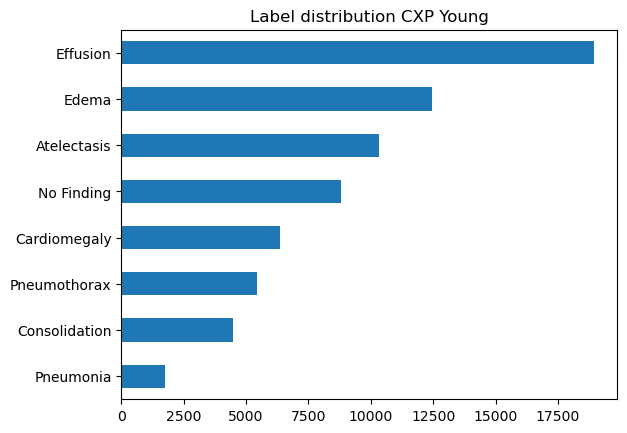

In [103]:
# plot the label distribution for the two sets
label_distribution_young = df_train_val_young[common_diseases].sum()
label_distribution_old = df_train_val_old[common_diseases].sum()
# plot as a horizontal bar chart, sorted
label_distribution_young.sort_values().plot(kind="barh", title="Label distribution CXP Young")

<Axes: title={'center': 'Label distribution CXP Old'}>

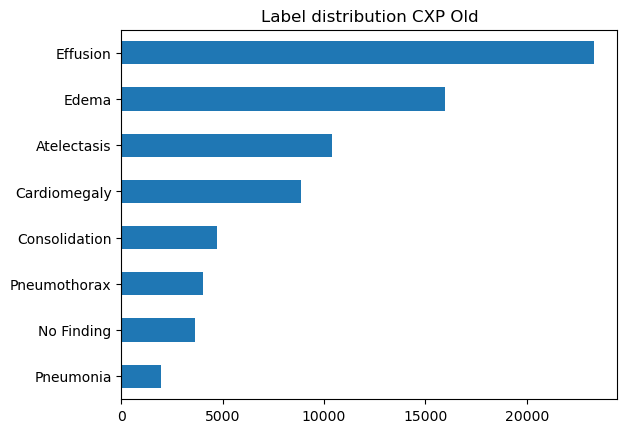

In [104]:
label_distribution_old.sort_values().plot(kind="barh", title="Label distribution CXP Old")

In [115]:
# split each training set to training and validation
# find the number of unique patients
patients_young = df_train_val_young['Patient ID'].unique()
patients_old = df_train_val_old['Patient ID'].unique()
# shuffle the patients
np.random.seed(44)
np.random.shuffle(patients_young)
np.random.shuffle(patients_old)
# check how many images the first 8k patients have
len(df_train_val_young[df_train_val_young['Patient ID'].isin(patients_young[:7489])]), len(df_train_val_old[df_train_val_old['Patient ID'].isin(patients_old[:7264])])

# save the first 7489 patients to as the validation set
df_val_young = df_train_val_young[df_train_val_young['Patient ID'].isin(patients_young[:7489])]
df_train_young = df_train_val_young[~df_train_val_young['Patient ID'].isin(patients_young[:7489])]
# save the first 7264 patients to as the validation set
df_val_old = df_train_val_old[df_train_val_old['Patient ID'].isin(patients_old[:7264])]
df_train_old = df_train_val_old[~df_train_val_old['Patient ID'].isin(patients_old[:7264])]
# save the training and validation files
df_train_young.to_csv("cxp_train_young.csv", index=False)
df_val_young.to_csv("cxp_val_young.csv", index=False)
df_train_old.to_csv("cxp_train_old.csv", index=False)
df_val_old.to_csv("cxp_val_old.csv", index=False)

In [116]:
len(df_train_young), len(df_val_young), len(df_train_old), len(df_val_old)

(31092, 15000, 29703, 15000)

In [19]:
# Now we want to split the cxp test set into young and old
# use the original dataframe to add the age column to the test set
df_original = pd.read_csv('train.csv', usecols=['Path', 'Age'])

# process the path column to remove the first part of the path and keep only the filename
df_original['Path'] = df_original['Path'].str.replace("CheXpert-v1.0/train/", "").str.replace("/", "_")
# use the original dataframe to add the age column to the training and validation set
df_test = pd.read_csv("cxp_test.csv")
df_test = df_test.merge(df_original, on="Path")

age_median_test = df_test['Age'].median()
age_median_traival = 63.0
age_median_test, age_median_traival
 


(62.0, 63.0)

In [23]:
df_test_young = df_test[df_test['Age'] < age_median_traival]
df_test_old = df_test[df_test['Age'] >= age_median_traival]
# if there are common patients between the two sets
# put all their rows in the traianing set
common_patients = set(df_test_young['Patient ID']).intersection(set(df_test_old['Patient ID']))
# move the rows of the common patients to the young set
df_test_young = pd.concat([
    df_test_young,
    df_test_old[df_test_old['Patient ID'].isin(common_patients)]
    ],
    ignore_index=True
)
# remove the rows of the common patients from the old set
df_test_old = df_test_old[~df_test_old['Patient ID'].isin(common_patients)]
# check the number of common patients
assert len(set(df_test_young['Patient ID']).intersection(set(df_test_old['Patient ID'] )) ) == 0
len(df_test_young), len(df_test_old)

(7797, 7203)

In [ ]:
# save the test sets
df_test_young.to_csv("cxp_test_young.csv", index=False)
df_test_old.to_csv("cxp_test_old.csv", index=False)

In [3]:
df_test_young= pd.read_csv("cxp_test_young.csv")
df_test_old = pd.read_csv("cxp_test_old.csv")
# drop the age and save
df_test_young.drop(columns=["Age"], inplace=True)
df_test_old.drop(columns=["Age"], inplace=True)
df_test_young.to_csv("cxp_test_young.csv", index=False)
df_test_old.to_csv("cxp_test_old.csv", index=False)